In [1]:
import numpy as np
import pandas as pd

### 데이터 불러오기

In [2]:
train  = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

train = train.drop(['index'],axis = 1)
test =test.drop(['index'],axis = 1)

### 데이터 전처리(응답시간)

In [3]:
concat_features = train

mask = concat_features.introelapse > (concat_features.introelapse.quantile(0.75) + 
    1.5 * (concat_features.introelapse.quantile(0.75) - 
    concat_features.introelapse.quantile(0.25)))
    
concat_features.introelapse[mask] = concat_features.introelapse.quantile(0.75)

mask = concat_features.testelapse > (concat_features.testelapse.quantile(0.75) + 1.5 * (concat_features.testelapse.quantile(0.75) - concat_features.testelapse.quantile(0.25)))
concat_features.testelapse[mask] = concat_features.testelapse.quantile(0.75)

mask = concat_features.surveyelapse > (concat_features.surveyelapse.quantile(0.75) + 1.5 * (concat_features.surveyelapse.quantile(0.75) - concat_features.surveyelapse.quantile(0.25)))
concat_features.surveyelapse[mask] = concat_features.surveyelapse.quantile(0.75)

train = concat_features



concat_features = test

mask = concat_features.introelapse > (concat_features.introelapse.quantile(0.75) + 1.5 * (concat_features.introelapse.quantile(0.75) - concat_features.introelapse.quantile(0.25)))
concat_features.introelapse[mask] = concat_features.introelapse.quantile(0.75)

mask = concat_features.testelapse > (concat_features.testelapse.quantile(0.75) + 1.5 * (concat_features.testelapse.quantile(0.75) - concat_features.testelapse.quantile(0.25)))
concat_features.testelapse[mask] = concat_features.testelapse.quantile(0.75)

mask = concat_features.surveyelapse > (concat_features.surveyelapse.quantile(0.75) + 1.5 * (concat_features.surveyelapse.quantile(0.75) - concat_features.surveyelapse.quantile(0.25)))
concat_features.surveyelapse[mask] = concat_features.surveyelapse.quantile(0.75)

test = concat_features


C:\Users\JeongWoo\AppData\Local\Temp\ipykernel_2052\855289236.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_features.introelapse[mask] = concat_features.introelapse.quantile(0.75)
C:\Users\JeongWoo\AppData\Local\Temp\ipykernel_2052\855289236.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_features.testelapse[mask] = concat_features.testelapse.quantile(0.75)
C:\Users\JeongWoo\AppData\Local\Temp\ipykernel_2052\855289236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

### 데이터 전처리(나이)

In [4]:
train.loc[train['age'] == 0, 'age'] = train['age'].mean()
test.loc[test['age'] == 0, 'age'] = train['age'].mean()

In [5]:
train.loc[train['age'] > 65, 'age'] = 0
test.loc[test['age'] > 65, 'age'] = 0

### 데이터 전처리(가족 수)

In [6]:
train.loc[train['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]
test.loc[test['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]

### 파라미터 값 조정(원 핫 인코딩)

In [7]:
for name in ['education', 'urban', 'gender', 'engnat', 'hand', 'religion',
            'voted', 'married']:

    mergedata = pd.get_dummies(train[name], prefix = name)
    train = pd.concat([train, mergedata], axis=1)
    train = train.drop([name], axis = 1)

In [8]:
for name in ['education', 'urban', 'gender', 'engnat', 'hand', 'religion',
            'voted', 'married']:

    mergedata = pd.get_dummies(test[name], prefix = name)
    test = pd.concat([test, mergedata], axis=1)
    test = test.drop([name], axis = 1)

### 데이터 전처리(나라 - 라벨인코딩)

In [9]:
from sklearn.preprocessing import LabelEncoder
ex = LabelEncoder()

con8 = train.country.value_counts().keys()[:6]

for i in range(train.count().max()):
    if(train.country.values[i] not in con8):
        train.country.values[i] = "X"

for i in range(test.count().max()):
    if(test.country.values[i] not in con8):
        test.country.values[i] = "X"

train.country = ex.fit_transform(train.country)

test.country = ex.fit_transform(test.country)

In [10]:
train['Ex'] = train['TIPI1']-train['TIPI6']
train['Ag'] = train['TIPI7']-train['TIPI2']
train['Con'] = train['TIPI3']-train['TIPI8']
train['Es'] =train['TIPI9']-train['TIPI4']
train['Op'] =train['TIPI5']-train['TIPI10']

In [11]:
test['Ex'] = test['TIPI1']-test['TIPI6']
test['Ag'] = test['TIPI7']-test['TIPI2']
test['Con'] = test['TIPI3']-test['TIPI8']
test['Es'] =test['TIPI9']-test['TIPI4']
test['Op'] =test['TIPI5']-test['TIPI10']

In [12]:
train = train.drop(['TIPI1','TIPI2','TIPI3','TIPI4','TIPI5',
                   'TIPI6','TIPI7','TIPI8','TIPI9','TIPI10'],axis = 1)

test = test.drop(['TIPI1','TIPI2','TIPI3','TIPI4','TIPI5',
                   'TIPI6','TIPI7','TIPI8','TIPI9','TIPI10'],axis = 1)

### pycaret 모델 학습

### setting

In [13]:
from pycaret.classification import *

model = setup(data = train, target = 'nerdiness',use_gpu=True,session_id=2023, normalize = True, normalize_method = 'zscore',transformation=True,train_size=0.85)

,Description,Value
0,session_id,2023
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 89)"
5,Missing Values,True
6,Numeric Features,38
7,Categorical Features,50
8,Ordinal Features,False
9,High Cardinality Features,False


### 모델 비교

In [14]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7813,0.8685,0.8439,0.7811,0.8112,0.5523,0.5548,0.9310
et,Extra Trees Classifier,0.7805,0.8719,0.8401,0.7820,0.8099,0.5509,0.5530,1.0900
xgboost,Extreme Gradient Boosting,0.7637,0.8302,0.8163,0.7723,0.7936,0.5177,0.5188,0.8660
catboost,CatBoost Classifier,0.7560,0.8289,0.8203,0.7604,0.7892,0.5005,0.5027,7.5500
lightgbm,Light Gradient Boosting Machine,0.7496,0.8220,0.8146,0.7551,0.7836,0.4876,0.4898,1.3810
gbc,Gradient Boosting Classifier,0.7321,0.8005,0.7999,0.7400,0.7687,0.4514,0.4535,5.8850
ridge,Ridge Classifier,0.7295,0.0000,0.7930,0.7400,0.7655,0.4470,0.4486,0.0920
lda,Linear Discriminant Analysis,0.7294,0.7967,0.7926,0.7400,0.7653,0.4467,0.4482,0.5280
lr,Logistic Regression,0.7292,0.7975,0.7882,0.7418,0.7642,0.4469,0.4482,1.2760
ada,Ada Boost Classifier,0.7220,0.7895,0.7827,0.7353,0.7582,0.4321,0.4334,1.9260


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2023, verbose=0,
                       warm_start=False)

### 모델 생성

In [15]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7796,0.8594,0.8239,0.7895,0.8063,0.5509,0.5516
1,0.7953,0.8814,0.8493,0.7966,0.8221,0.5817,0.5833
2,0.7969,0.8874,0.8535,0.7963,0.8239,0.5846,0.5865
3,0.7788,0.8752,0.8592,0.7702,0.8123,0.5451,0.5499
4,0.7749,0.8651,0.8423,0.7736,0.8065,0.5387,0.5414
5,0.7663,0.8560,0.8366,0.7655,0.7995,0.5207,0.5237
6,0.7835,0.8664,0.8549,0.7782,0.8148,0.5558,0.5593
7,0.7906,0.8676,0.8547,0.7870,0.8195,0.5712,0.5739
8,0.7663,0.8551,0.8279,0.7693,0.7976,0.5220,0.5240


In [16]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7733,0.8647,0.8197,0.7833,0.8011,0.5380,0.5387
1,0.7992,0.8854,0.8493,0.8019,0.8249,0.5901,0.5914
2,0.7984,0.8870,0.8423,0.8048,0.8231,0.5891,0.5900
3,0.7882,0.8827,0.8479,0.7880,0.8168,0.5667,0.5688
4,0.7686,0.8715,0.8380,0.7677,0.8013,0.5256,0.5285
5,0.7576,0.8603,0.8282,0.7587,0.7919,0.5031,0.5059
6,0.7741,0.8633,0.8465,0.7705,0.8067,0.5365,0.5399
7,0.7796,0.8670,0.8392,0.7808,0.8090,0.5493,0.5513
8,0.7843,0.8659,0.8364,0.7886,0.8118,0.5598,0.5611


In [17]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7341,0.8134,0.7761,0.7538,0.7647,0.4592,0.4595
1,0.7663,0.8331,0.8056,0.7814,0.7933,0.5245,0.5249
2,0.7639,0.8467,0.8352,0.7632,0.7976,0.5158,0.5188
3,0.7624,0.8340,0.8366,0.7606,0.7968,0.5122,0.5156
4,0.7420,0.8140,0.8070,0.7490,0.7769,0.4719,0.4738
5,0.7349,0.8082,0.8028,0.7422,0.7713,0.4572,0.4592
6,0.7498,0.8202,0.8268,0.7497,0.7863,0.4863,0.4897
7,0.7459,0.8071,0.8039,0.7550,0.7787,0.4810,0.4823
8,0.7365,0.8070,0.8166,0.7376,0.7751,0.4589,0.4624


### 모델 세가지 여러 방식으로 앙상블

In [18]:
blended1 = blend_models(estimator_list = [et,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7773,0.8661,0.8296,0.7832,0.8057,0.5452,0.5465
1,0.7922,0.8871,0.8451,0.7947,0.8191,0.5754,0.5769
2,0.8008,0.8902,0.8521,0.8024,0.8265,0.5931,0.5946
3,0.7820,0.8827,0.8521,0.7776,0.8132,0.5527,0.5560
4,0.7757,0.8721,0.8507,0.7704,0.8086,0.5393,0.5432
5,0.7569,0.8616,0.8338,0.7551,0.7925,0.5007,0.5043
6,0.7765,0.8691,0.8577,0.7680,0.8104,0.5402,0.5451
7,0.7835,0.8710,0.8491,0.7808,0.8135,0.5566,0.5594
8,0.7812,0.8648,0.8378,0.7836,0.8098,0.5529,0.5546


In [19]:
blended2 = blend_models(estimator_list = [lightgbm,et], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7796,0.8606,0.8169,0.7934,0.8050,0.5517,0.5520
1,0.8063,0.8831,0.8423,0.8158,0.8288,0.6058,0.6062
2,0.8008,0.8903,0.8507,0.8032,0.8263,0.5933,0.5946
3,0.7906,0.8800,0.8535,0.7880,0.8195,0.5711,0.5737
4,0.7851,0.8683,0.8493,0.7831,0.8149,0.5598,0.5624
5,0.7741,0.8602,0.8310,0.7784,0.8038,0.5383,0.5399
6,0.7890,0.8650,0.8606,0.7823,0.8196,0.5670,0.5707
7,0.7937,0.8609,0.8505,0.7934,0.8210,0.5784,0.5803
8,0.7741,0.8600,0.8420,0.7723,0.8057,0.5372,0.5401


In [20]:
blended3 = blend_models(estimator_list = [lightgbm,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7686,0.8482,0.8127,0.7808,0.7964,0.5287,0.5293
1,0.7929,0.8706,0.8366,0.8005,0.8182,0.5780,0.5788
2,0.7953,0.8807,0.8606,0.7904,0.8240,0.5804,0.5834
3,0.7835,0.8680,0.8535,0.7789,0.8145,0.5559,0.5593
4,0.7694,0.8544,0.8408,0.7674,0.8024,0.5270,0.5301
5,0.7749,0.8474,0.8394,0.7750,0.8059,0.5390,0.5414
6,0.7859,0.8566,0.8620,0.7776,0.8176,0.5600,0.5644
7,0.7765,0.8502,0.8406,0.7760,0.8070,0.5424,0.5449
8,0.7702,0.8437,0.8420,0.7674,0.8030,0.5287,0.5320


In [21]:
blended4 = blend_models(estimator_list = [lightgbm,et,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7820,0.8632,0.8268,0.7911,0.8085,0.5556,0.5564
1,0.8031,0.8858,0.8451,0.8097,0.8270,0.5989,0.5996
2,0.7984,0.8922,0.8549,0.7976,0.8253,0.5878,0.5898
3,0.7906,0.8819,0.8606,0.7843,0.8207,0.5703,0.5739
4,0.7749,0.8706,0.8423,0.7736,0.8065,0.5387,0.5414
5,0.7757,0.8625,0.8380,0.7768,0.8062,0.5408,0.5430
6,0.7929,0.8689,0.8634,0.7859,0.8228,0.5751,0.5788
7,0.7851,0.8662,0.8477,0.7836,0.8144,0.5602,0.5626
8,0.7788,0.8613,0.8434,0.7776,0.8092,0.5472,0.5497


### 학습 정확도 및 시각화

In [22]:
pred_holdout = predict_model(blended1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7828,0.8806,0.8557,0.7661,0.8085,0.5593,0.5639


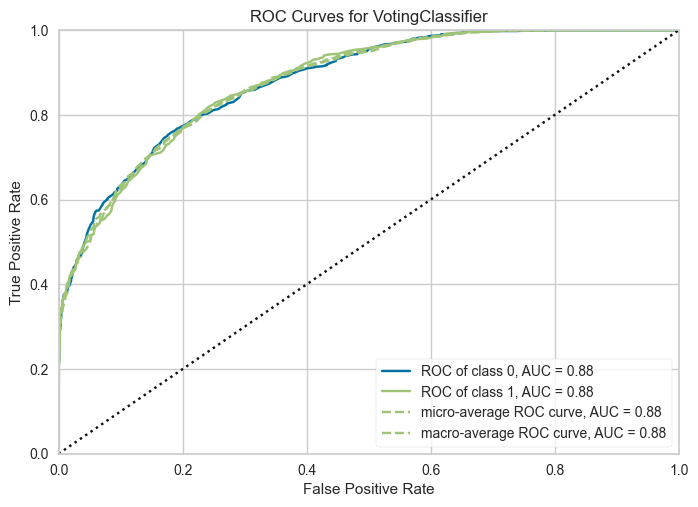

In [23]:
plot_model(blended1)

In [24]:
pred_holdout = predict_model(blended2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7881,0.8760,0.8491,0.7763,0.8111,0.5709,0.5739


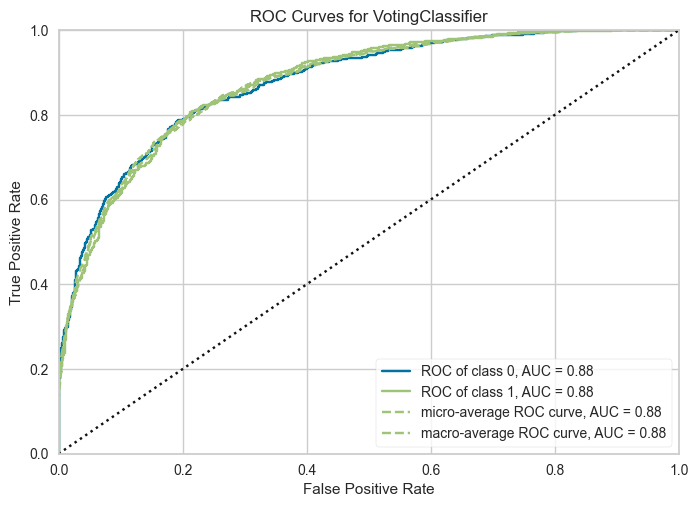

In [25]:
plot_model(blended2)

In [26]:
pred_holdout = predict_model(blended3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7819,0.8626,0.8507,0.7674,0.8069,0.5578,0.5617


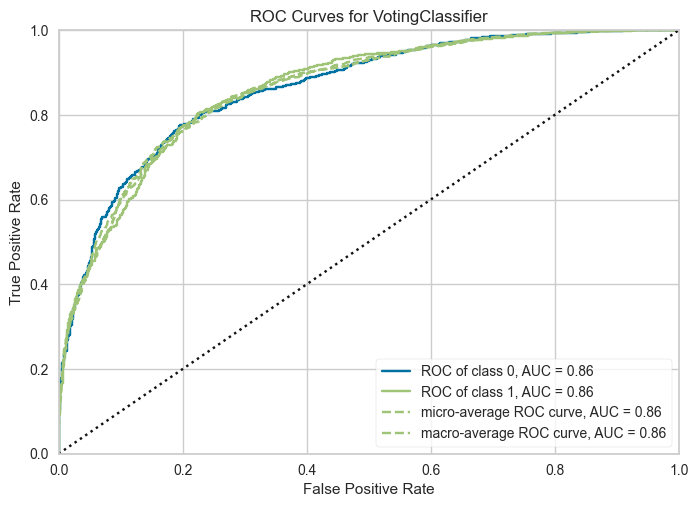

In [27]:
plot_model(blended3)

In [28]:
pred_holdout = predict_model(blended4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7868,0.8786,0.8549,0.7717,0.8112,0.5677,0.5717


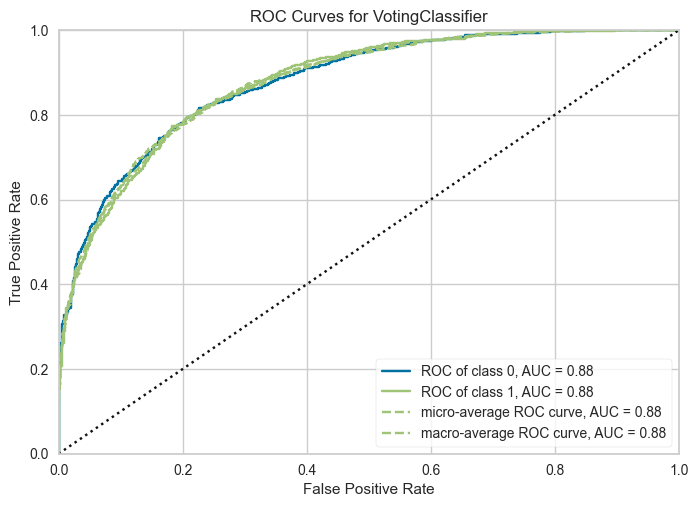

In [29]:
plot_model(blended4)

### 결과 저장

In [30]:
final_model = finalize_model(blended1)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit16_1.csv", index = False)

In [ ]:
final_model = finalize_model(blended2)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit16_2.csv", index = False)

In [ ]:
final_model = finalize_model(blended3)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit16_3.csv", index = False)

In [ ]:
final_model = finalize_model(blended4)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit16_4.csv", index = False)